
#### Comparing Matrix Profile Model (new approach) to existing anomaly models

References
* https://www.cs.umn.edu/research/technical_reports/view/09-004
* https://www.cs.ucr.edu/~eamonn/Matrix_Profile_Tutorial_Part1.pdf
* https://towardsdatascience.com/the-matrix-profile-e4a679269692

General approach
* read and transform raw data
* run pipeline anomaly functions
* run the matrix profile
* compare results

<br>

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from src.comparingmodels import (utils, data, models)

import logging
from iotfunctions.enginelog import EngineLogging
EngineLogging.configure_console_logging(logging.INFO)

%load_ext autoreload
%autoreload 2
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/iotfunctions/bif.py:1884: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


#### STEPS TO ANALYZE ANOMALY MODELS FOR A GIVEN DATASET <br>
For a given data run the following cells in order <br>

**1. Data Processing** describes the data we want to analyze<br>
**2. Running existing anomaly models** runs the models and summarizes all the anomaly scores calculated from existing model<br>
**3. Visualizing the result** plots the anomaly scores calculated above<br>
**4. Matrix Profile - Anomaly Detection** calculates the matrix profile and plots the anomaly score derived from it<br>


### DATA 1: Public Temperature data

**1. Data Processing**

In [34]:
dp = data.DataProcessor(filepath='../data/AzureAnomalysample.csv', timestampcolumn='timestamp')
dp.add_entity('MyRoom')
dp.add_derived_column('Temperature', 'value', 20)
dp.process_data()
df_i = dp.get_data()
df_i = df_i.drop(columns=['value'])
#column we want to analyze
columnname='Temperature'

df_i.describe()

[autoreload of ipykernel.iostream failed: Traceback (most recent call last):
  File "/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
  File "/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/

2020-07-29T12:11:30.614 WARNING matplotlib._rc_params_in_file Bad val '6, 6' on line #20
	"lines.dashed_pattern : 6, 6
"
	in file "/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle"
	name '_str_err_msg' is not defined
2020-07-29T12:11:30.619 WARNING matplotlib._rc_params_in_file Bad val '3, 5, 1, 5' on line #21
	"lines.dashdot_pattern : 3, 5, 1, 5
"
	in file "/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle"
	name '_str_err_msg' is not defined
2020-07-29T12:11:30.620 WARNING matplotlib._rc_params_in_file Bad val '1, 3' on line #22
	"lines.dotted_pattern : 1, 3
"
	in file "/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle"
	name '_str_err_msg' is not defined
2020-07-29T12:11:30.621 WARNING matplotlib._rc_params_in_file Bad val '-7, 7' on line #186
	"axes.formatter.limits : -7, 7 # use 


Bad key "text.kerning_factor" on line 4 in
/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
[autoreload of matplotlib.style.core failed: Traceback (most recent call last):
  File "/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Applications/anaconda3/envs/ml_mmfunctions/

TypeError: descriptor 'axes' for 'BlockManager' objects doesn't apply to 'SingleBlockManager' object

Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x7fcb373da200> (for post_run_cell):


AttributeError: module 'matplotlib' has no attribute 'backends'

**2. Running existing anomaly models**

In [25]:
#Define ExistingModels with the column we want to run the scoring on
em = models.ExistingModels(columnname=columnname)
df_anomaly = em.run_all(df_i)
df_anomaly.describe()

2020-07-22T08:19:55.259 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-07-22T08:19:55.260 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-07-22T08:19:55.425 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-07-22T08:19:55.426 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
Saliency   Entity: MyRoom, result shape: (665,) score shape: (665,) input shape: (4000,)
2020-07-22T08:19:56.156 INFO iotfunctions.anomaly.__init__ Expression: None
2020-07-22T08:19:56.157 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-07-22T08:19:56.157 WARNING iotfunctions.metadata.__init__ Created a 

,Temperature,SpectralAnomalyScore,SaliencyAnomalyScore,KmeansAnomalyScore,FFTAnomalyScore
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,24.264336,7.936961,91.612342,0.708879,87.619858
std,1.484244,29.140010,558.067237,1.037884,337.289163
min,20.000000,0.048718,0.915668,0.000000,0.000000
25%,23.062500,3.809004,7.243777,0.363993,8.628128
50%,24.000000,4.482759,16.358672,0.467382,13.599039
75%,25.437500,5.051216,33.676496,0.569692,19.978545
max,30.750000,815.618754,10266.024478,7.221535,4483.238628


**3. Visualizing the result**

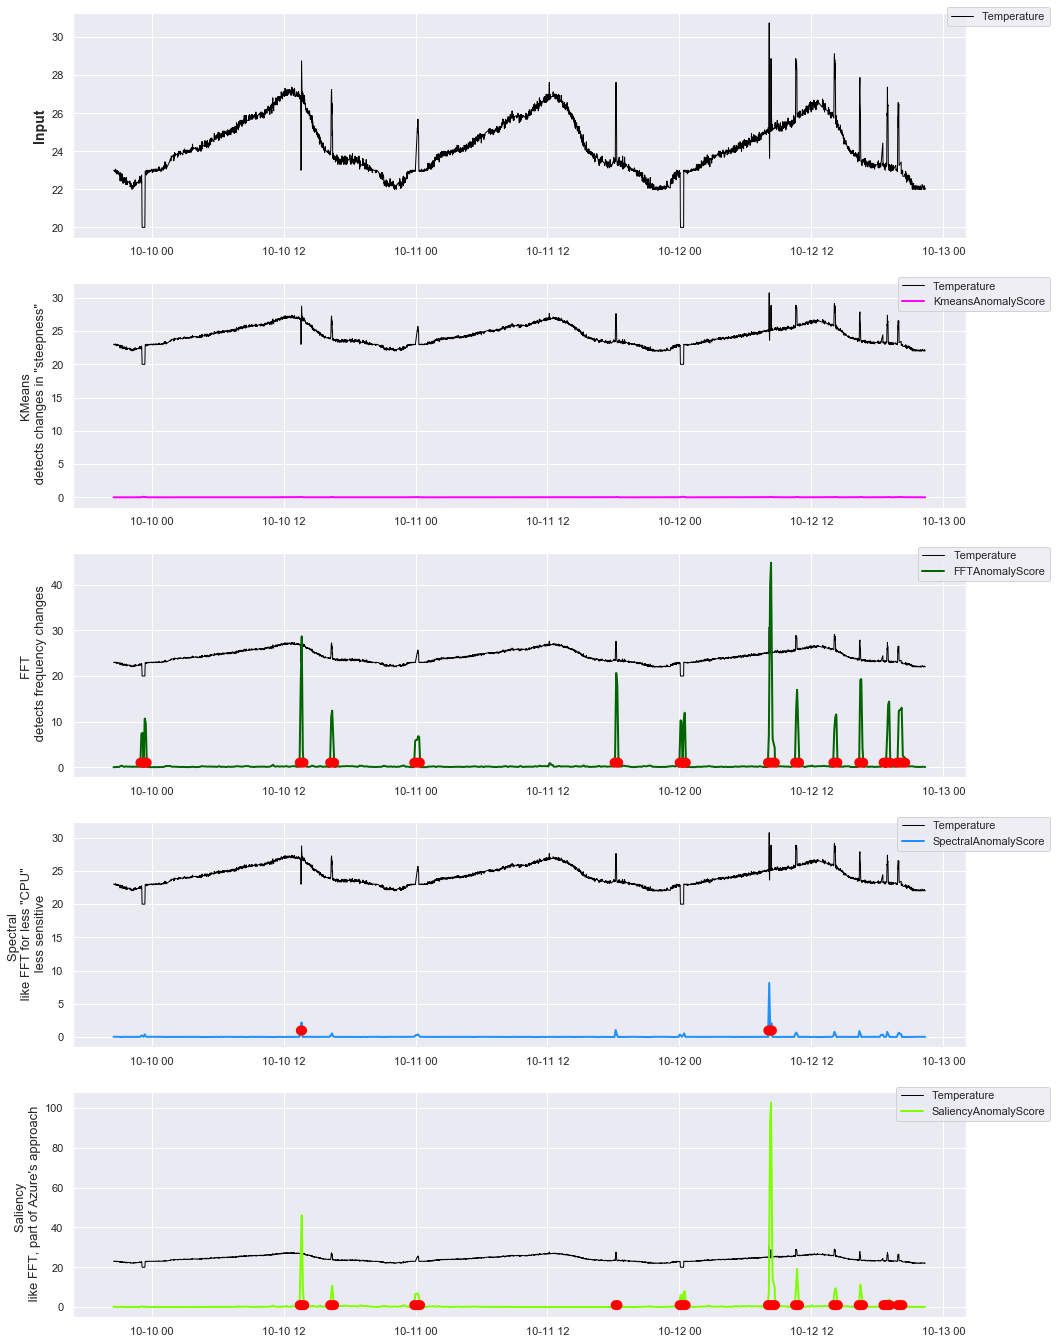

In [26]:
# Simplify dataframe to prepare input for plotting
df_plot = df_anomaly.loc[['MyRoom']]
df_plot.reset_index(level=[0], inplace=True)
em.plot_all(df_plot)

***NEW MODEL*** <br>
**4. Matrix Profile - Anomaly Detection**

1

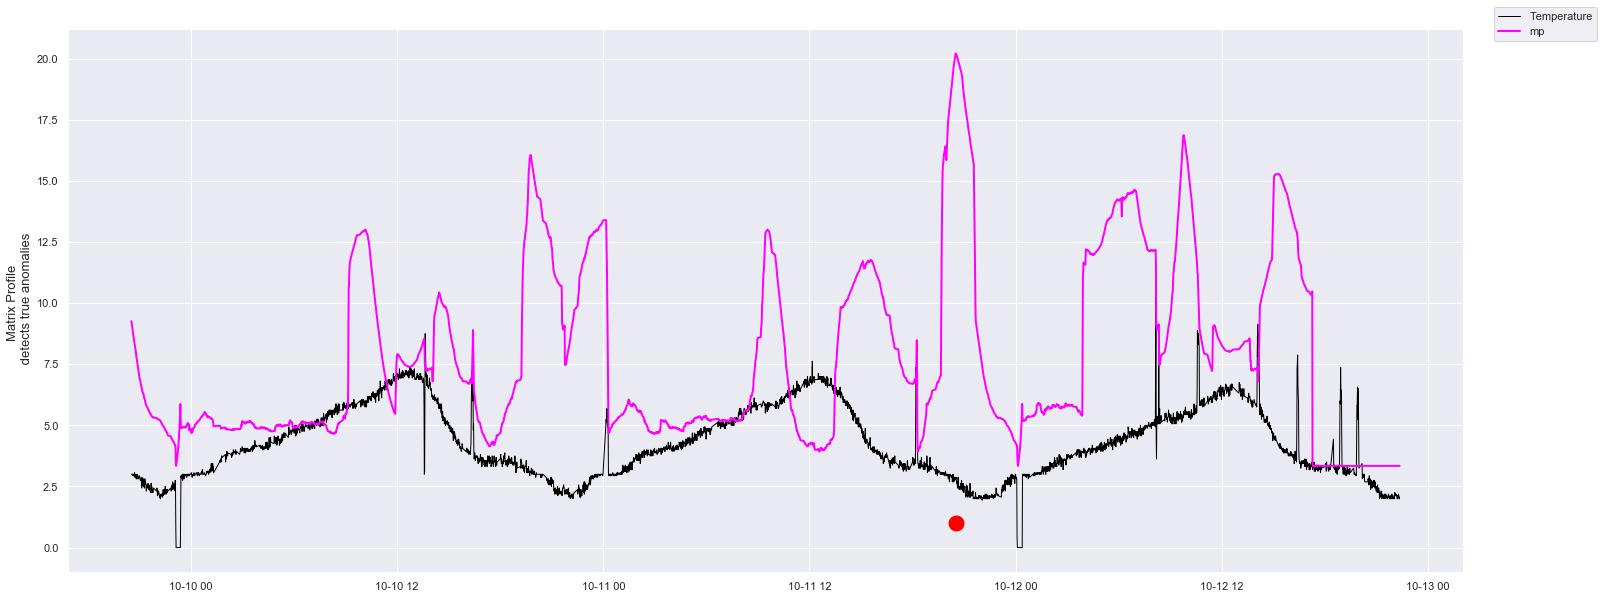

In [29]:
#Matrix Profile
window_size = 256
mp = models.MatrixProfile(df=df_i, columnname=columnname, windowsize=window_size,)
mp.run_model()
mp.plot_mp(columnsub=20)

### DATA 2: Good Data from Armstark

**1. Data Processing**

In [30]:
# customer data - good
dp = data.DataProcessor(filepath='../data/Armstark04714B6046D5.csv', timestampcolumn='RCV_TIMESTAMP_UTC')
dp.change_column_name('entity', 'DEVICE_ID')
dp.change_column_name('timestamp', 'RCV_TIMESTAMP_UTC')
dp.process_data()
df_i = dp.get_data()
df_i.describe()

#filter data to specific needs
listAttr = ['timestamp', 'entity', 'vibrations', 'rms', 'accel_speed', 'accel_power_0', 'accel_power_1',
            'accel_power_2', 'accel_power_3', 'accel_power_4']
utils.l2norm(df_i, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
utils.l2norm(df_i, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
utils.l2norm(df_i, 'accel_speed', 'ACCEL_SPEED')
utils.unrollAccel(df_i)

#colum we want to analyze
columnname = 'vibrations'

df_i = df_i.filter(listAttr, axis=1)
df_i.describe()

,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4
count,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000
mean,3.759047,2.170460,2208.854495,2.453523,2.453312,2.452808,2.452053,2.452439
std,0.033272,0.002922,589.925540,0.856247,0.857594,0.857678,0.857200,0.856340
min,3.616515,2.155864,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.737696,2.169444,2316.566425,2.251800,2.251800,2.252000,2.252000,2.251800
50%,3.757949,2.170800,2318.802493,2.313800,2.313400,2.311800,2.312200,2.312600
75%,3.780154,2.171949,2379.176328,2.691450,2.692100,2.685100,2.681850,2.682300
max,3.898555,2.184292,2672.101233,5.325799,5.293200,5.334001,5.278600,5.282000


**2. Running Existing Anomaly models**

In [21]:
#Define ExistingModels with the column we want to run the scoring on
em = models.ExistingModels(columnname=columnname)
df_anomaly = em.run_all(df_i)
df_anomaly.describe()

2020-07-22T08:18:32.257 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-07-22T08:18:32.258 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-07-22T08:18:32.678 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-07-22T08:18:32.679 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
Saliency   Entity: 04714B6046D5, result shape: (1435,) score shape: (1435,) input shape: (8620,)
2020-07-22T08:18:33.681 INFO iotfunctions.anomaly.__init__ Expression: None
2020-07-22T08:18:33.682 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-07-22T08:18:33.683 WARNING iotfunctions.metadata.__init__ Cr

,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,SpectralAnomalyScore,SaliencyAnomalyScore,KmeansAnomalyScore,FFTAnomalyScore
count,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000
mean,3.759047,2.170460,2208.854495,2.453523,2.453312,2.452808,2.452053,2.452439,25.345980,18.978313,0.085765,13.823910
std,0.033272,0.002922,589.925540,0.856247,0.857594,0.857678,0.857200,0.856340,21.227814,15.381316,0.024230,7.713424
min,3.616515,2.155864,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022866,0.584772,0.017958,1.287713
25%,3.737696,2.169444,2316.566425,2.251800,2.251800,2.252000,2.252000,2.251800,12.862771,6.381826,0.070405,8.780276
50%,3.757949,2.170800,2318.802493,2.313800,2.313400,2.311800,2.312200,2.312600,21.263598,15.753592,0.083716,12.316232
75%,3.780154,2.171949,2379.176328,2.691450,2.692100,2.685100,2.681850,2.682300,31.197267,27.489176,0.098963,17.408063
max,3.898555,2.184292,2672.101233,5.325799,5.293200,5.334001,5.278600,5.282000,302.867105,99.660201,0.201435,61.072351


**3. Visualize the result**

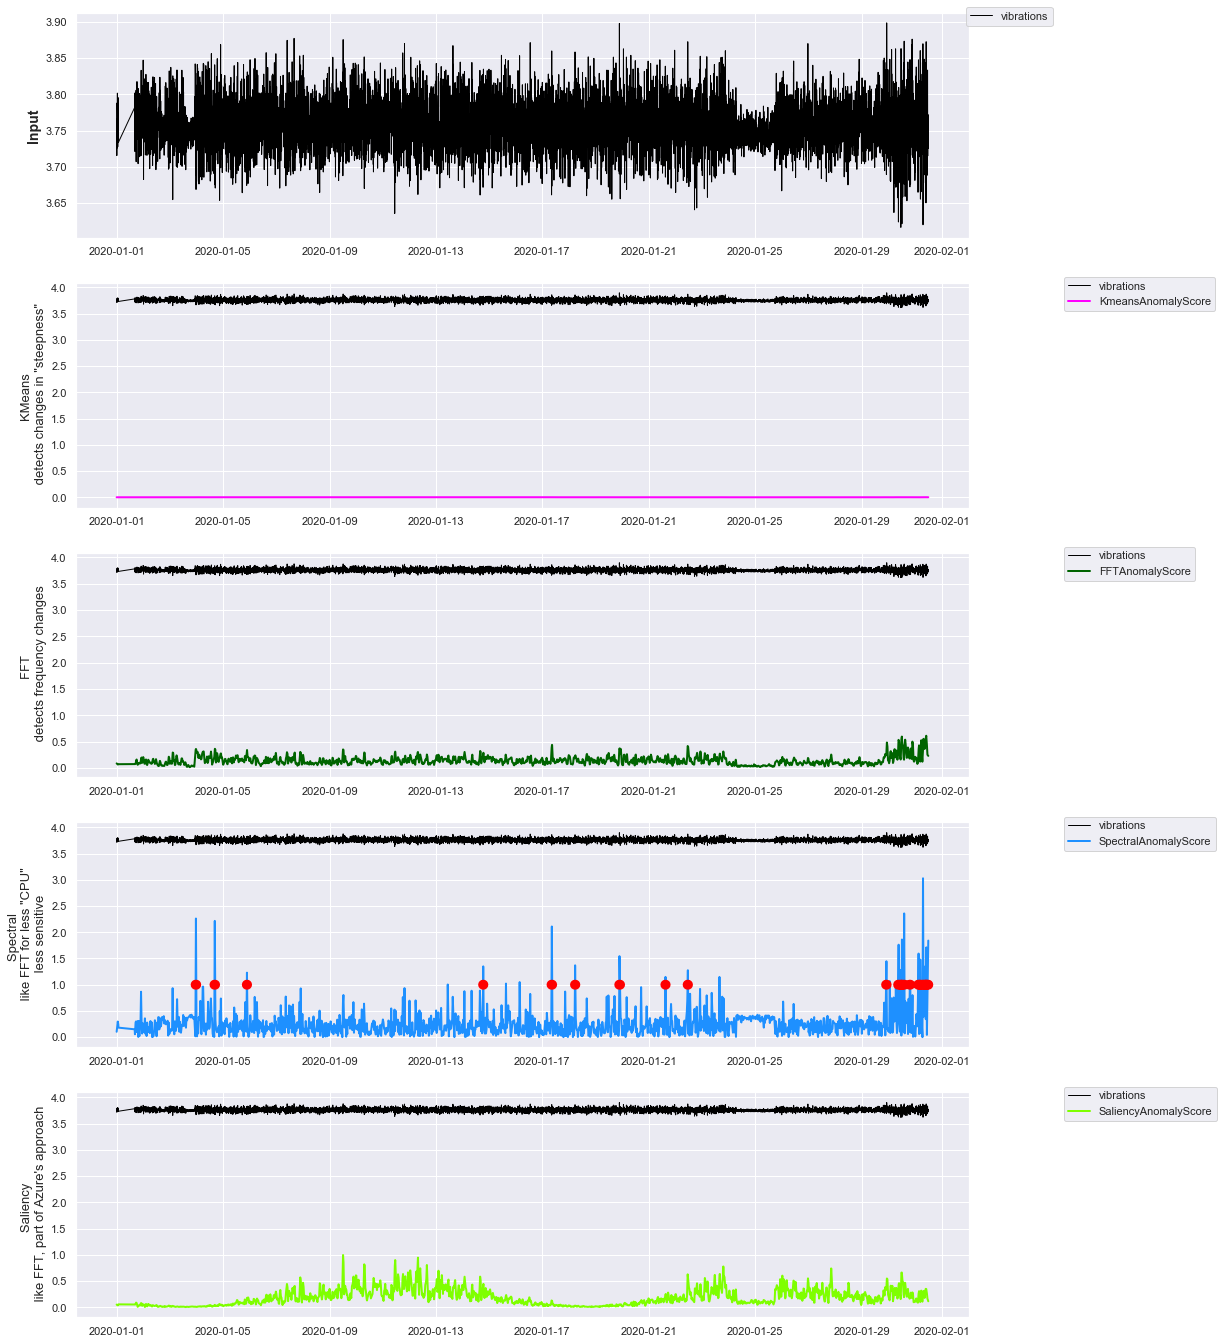

In [22]:
df_plot = df_anomaly.loc[['04714B6046D5']]
df_plot.reset_index(level=[0], inplace=True)
em.plot_all(df_plot)

***NEW MODEL*** <br>
**4. Matrix Profile - Anomaly Detection**

1

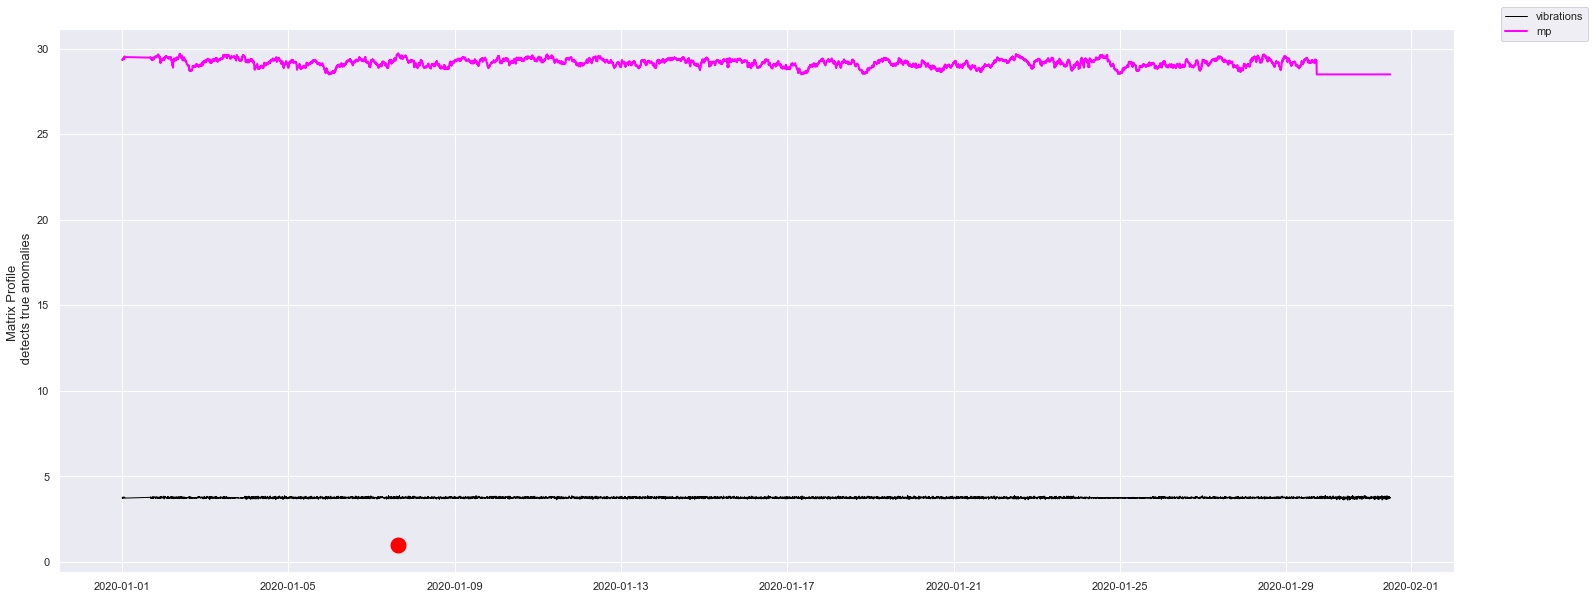

In [31]:
#Matrix Profile
window_size = 512
mp = models.MatrixProfile(df=df_i, columnname=columnname, windowsize=window_size,)
mp.run_model()
mp.plot_mp()

### DATA 3: Bad Data from Armstark

**1. Data Processing**

In [32]:
# customer data
dp = data.DataProcessor(filepath='../data/Armstark04714B604101.csv', timestampcolumn='RCV_TIMESTAMP_UTC')
dp.change_column_name('entity', 'DEVICE_ID')
dp.change_column_name('timestamp', 'RCV_TIMESTAMP_UTC')
dp.process_data()
df_i = dp.get_data()
df_i.describe()

#filter data to specific needs
listAttr = ['timestamp', 'entity', 'vibrations', 'rms', 'accel_speed', 'accel_power_0', 'accel_power_1',
            'accel_power_2', 'accel_power_3', 'accel_power_4']
utils.l2norm(df_i, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
utils.l2norm(df_i, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
utils.l2norm(df_i, 'accel_speed', 'ACCEL_SPEED')
utils.unrollAccel(df_i)

#column we want to analyze
columnname='vibrations'

df_i = df_i.filter(listAttr, axis=1)
df_i.describe()

,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4
count,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000
mean,3.714736,2.146044,2135.422189,2.408757,2.409634,2.407835,2.408529,2.409018
std,0.088517,0.015580,693.362789,0.947978,0.948468,0.947572,0.947615,0.947830
min,3.299344,2.120791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.664859,2.134649,2304.939479,2.268600,2.268400,2.268400,2.268000,2.268600
50%,3.701923,2.138430,2315.672257,2.352200,2.351000,2.349600,2.351600,2.352400
75%,3.758416,2.161545,2356.449660,2.666400,2.685000,2.670600,2.671000,2.675600
max,4.221860,2.194125,2647.057801,5.060000,4.975000,4.883400,5.401600,5.238200


**2. Run Existing Anomaly Models**

In [18]:
#Define ExistingModels with the column we want to run the scoring on
em = models.ExistingModels(columnname=columnname)
df_anomaly = em.run_all(df_i)
df_anomaly.describe()

2020-07-22T08:18:04.084 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-07-22T08:18:04.085 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-07-22T08:18:04.567 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-07-22T08:18:04.569 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
Saliency   Entity: 04714B604101, result shape: (1434,) score shape: (1434,) input shape: (8613,)
2020-07-22T08:18:05.728 INFO iotfunctions.anomaly.__init__ Expression: None
2020-07-22T08:18:05.728 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-07-22T08:18:05.729 WARNING iotfunctions.metadata.__init__ Cr

,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,SpectralAnomalyScore,SaliencyAnomalyScore,KmeansAnomalyScore,FFTAnomalyScore
count,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000
mean,3.714736,2.146044,2135.422189,2.408757,2.409634,2.407835,2.408529,2.409018,24.631320,28.688757,0.213877,26.145991
std,0.088517,0.015580,693.362789,0.947978,0.948468,0.947572,0.947615,0.947830,21.901951,31.822399,0.103929,24.792380
min,3.299344,2.120791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029583,0.786509,0.018507,0.785435
25%,3.664859,2.134649,2304.939479,2.268600,2.268400,2.268400,2.268000,2.268600,13.389962,6.515862,0.149818,9.096589
50%,3.701923,2.138430,2315.672257,2.352200,2.351000,2.349600,2.351600,2.352400,20.275315,17.250191,0.191107,15.653772
75%,3.758416,2.161545,2356.449660,2.666400,2.685000,2.670600,2.671000,2.675600,28.433519,36.710146,0.277062,38.706978
max,4.221860,2.194125,2647.057801,5.060000,4.975000,4.883400,5.401600,5.238200,271.556112,255.945241,0.580473,153.220474


**3. Visualize the output**

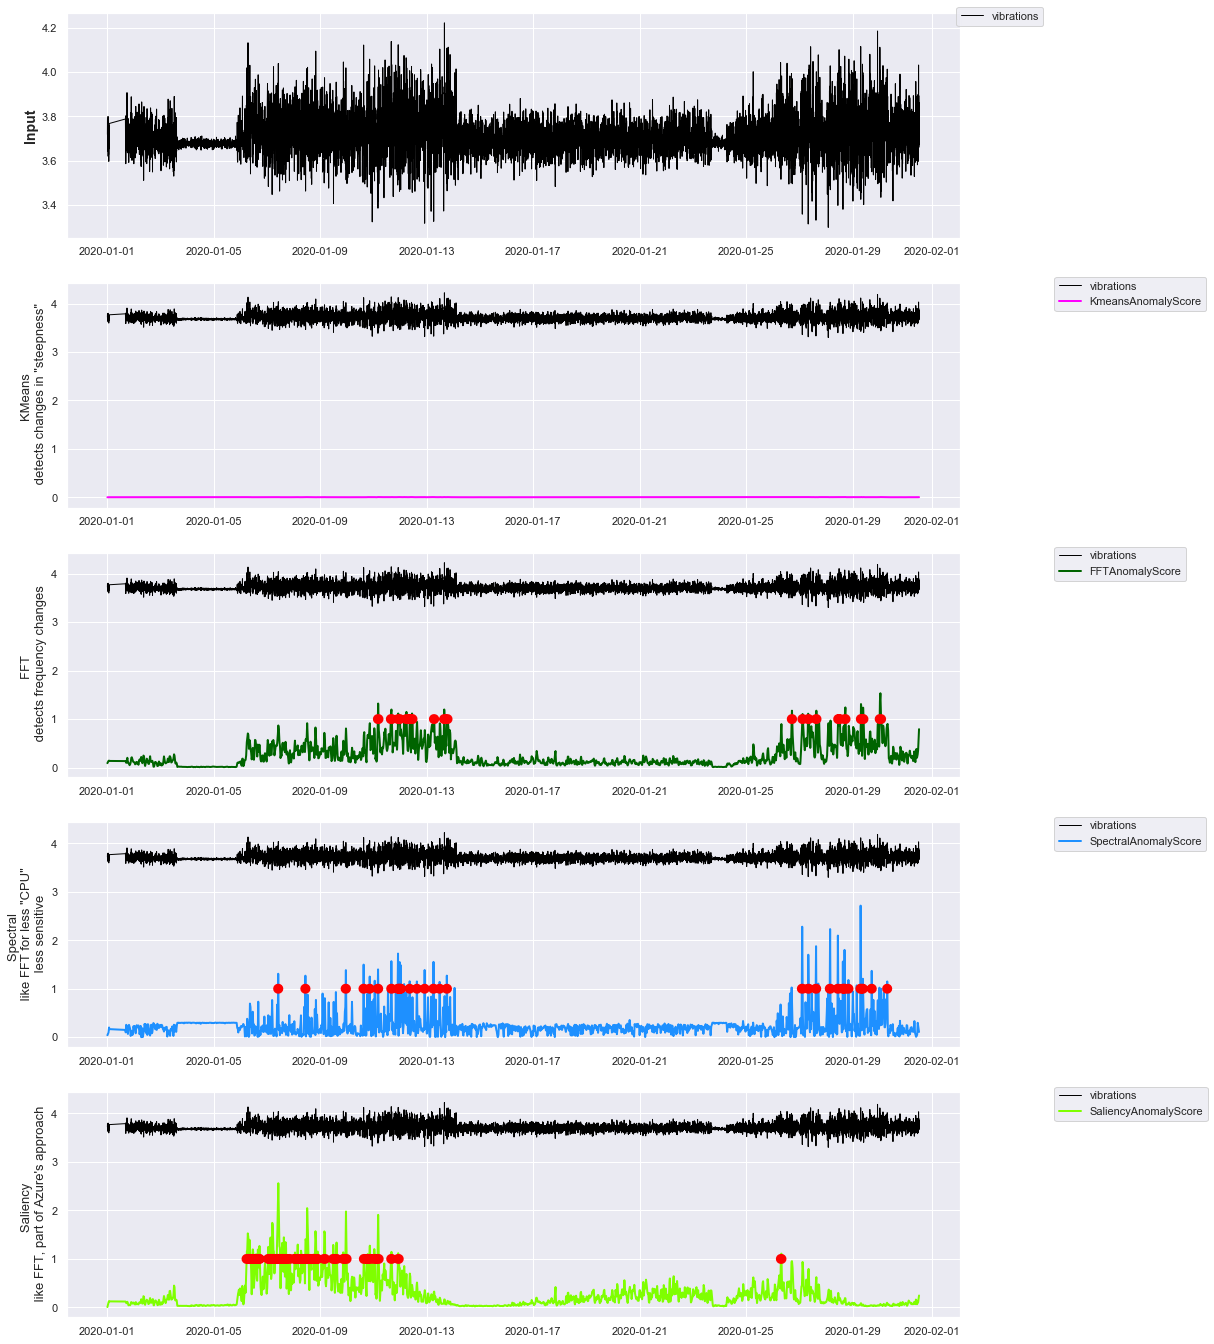

In [19]:
df_plot = df_anomaly.loc[['04714B604101']]
df_plot.reset_index(level=[0], inplace=True)
em.plot_all(df_plot)

***NEW MODEL <br>***
**4. Matrix Profile**

1

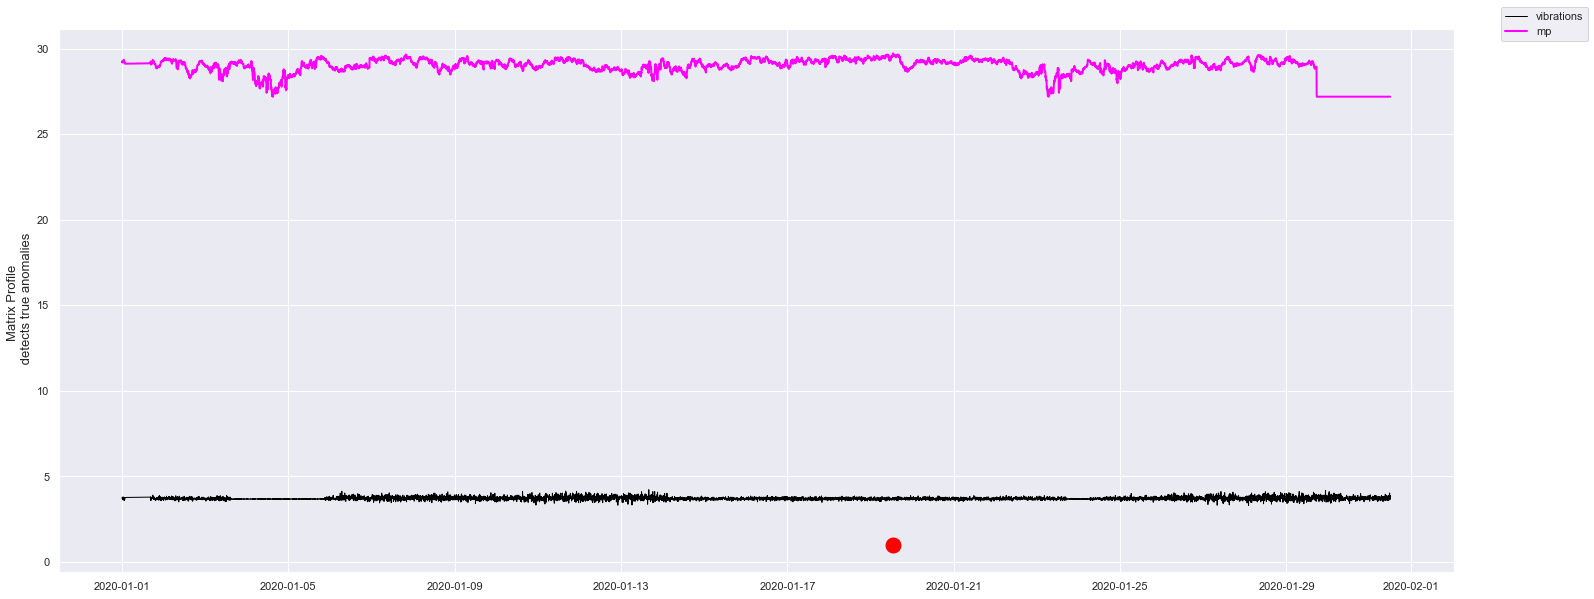

In [33]:
#Matrix Profile
window_size = 512
mp = models.MatrixProfile(df=df_i, columnname=columnname, windowsize=window_size,)
mp.run_model()
mp.plot_mp()